In [1]:
using AlgebraicPetri
using AlgebraicPetri.ModelComparison
using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Programs
using Catlab.WiringDiagrams
using Catlab.Graphics.Graphviz
using Catlab.Graphics.Graphviz: Html
using Plots
using JSON
using LabelledArrays
using PrettyTables
using Catlab.WiringDiagrams, Catlab.Graphics

using GraphViz

In [2]:
"""
Given a target model, determine if it is stratified by any pair of 
models from a list of candidates. 
"""
function decompose(tgt_model, candidate_legs) 
  stripped_tgt_model = remove_names(tgt_model)
  n = length(candidate_legs)
  res = []
  for i in 1:n 
    icand = remove_names(candidate_legs[i])
    for j in i:n 
      jcand = remove_names(candidate_legs[j])
      pb = first(legs(pullback(icand, jcand))) ⋅ icand
      if any(isomorphisms(dom(stripped_tgt_model), dom(pb))) do iso # copied from PR 709
          force(stripped_tgt_model) == force(iso ⋅ pb)
        end
          push!(res, candidate_legs[i]=>candidate_legs[j])
      end
    end
  end 
  return res
end

decompose

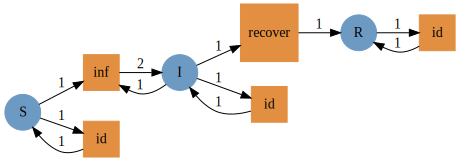

In [5]:
# Model 1
SIR = LabelledPetriNet([:S, :I, :R],
    :inf => ((:S,:I) => (:I,:I)),
    :recover => (:I=>:R),
    :id => (:S=>:S), :id=>(:I=>:I),:id=>(:R=>:R))
Graph(SIR)

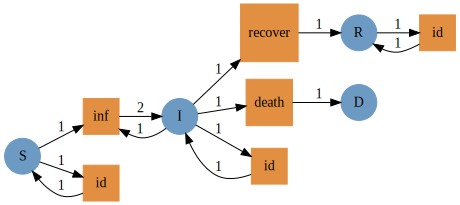

In [7]:
# Model 2
SIRD = LabelledPetriNet([:S, :I, :R, :D],
    :inf => ((:S,:I) => (:I,:I)),
    :recover => (:I=>:R),
    :death => (:I=>:D),
    :id => (:S=>:S), :id=>(:I=>:I),:id=>(:R=>:R))
Graph(SIRD)

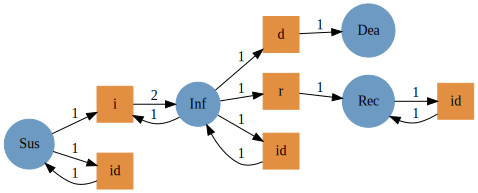

In [8]:
# Model 2a

"""An isomorphic version of SIRD that has different names and order of parts."""
SIRD2 = LabelledPetriNet([:Sus, :Inf, :Dea, :Rec],
    :d => (:Inf=>:Dea),
    :i => ((:Sus,:Inf) => (:Inf,:Inf)),
    :r => (:Inf=>:Rec),
    :id => (:Sus=>:Sus), :id=>(:Inf=>:Inf),:id=>(:Rec=>:Rec))
Graph(SIRD2)

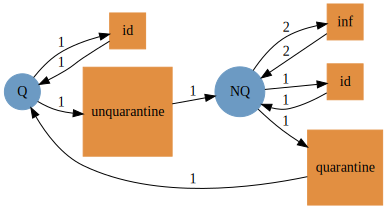

In [9]:
# Model 3
# One possible strata considered
Quarantine = LabelledPetriNet([:Q,:NQ],
    :inf => ((:NQ,:NQ)=>(:NQ,:NQ)),
    :id=>((:Q)=>(:Q)), 
    :id => ((:NQ) => (:NQ)),
    :quarantine => ((:NQ)=>(:Q)),
    :unquarantine => ((:Q)=>(:NQ)))
Graph(Quarantine)

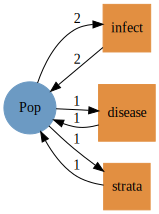

In [115]:
# Ontology related stuff
function strip_names(p::ACSetTransformation)
  init = NamedTuple([k=>collect(v) for (k,v) in pairs(components(p))])
  homomorphism(strip_names(dom(p)), strip_names(codom(p)), initial=init)
end

function strip_names(p::AbstractLabelledPetriNet)
  map(p, Name = name -> nothing)
end

infectious_ontology = LabelledPetriNet(
    [:Pop],
    :infect=>((:Pop, :Pop)=>(:Pop, :Pop)),
    :disease=>(:Pop=>:Pop),
    :strata=>(:Pop=>:Pop)
  )
Graph(infectious_ontology)

In [110]:
SIR_typed = homomorphism(SIR, strip_names(infectious_ontology);
    initial=(T=[1,2,3,3,3],I=[1,2,3,4,4,4],O=[1,2,3,4,4,4]),
    type_components=(Name=x->nothing,))

SIRD_typed = homomorphism(SIRD, strip_names(infectious_ontology);
  initial=(T=[1,2,2,3,3,3],I=[1,2,3,3,4,4,4],O=[1,2,3,3,4,4,4]),
  type_components=(Name=x->nothing,))

SIRD2_typed = homomorphism(SIRD2, strip_names(infectious_ontology);
    initial=(T=[2,1,2,3,3,3],I=[3,1,2,3,4,4,4],O=[3,1,2,3,4,4,4]),
    type_components=(Name=x->nothing,))

Quarantine_typed = homomorphism(Quarantine, strip_names(infectious_ontology);
    initial=(T=[1,2,2,3,3],I=Dict(1=>1,2=>2),O=Dict(1=>1,2=>2)), 
    type_components=(Name=x->nothing,))
1

1

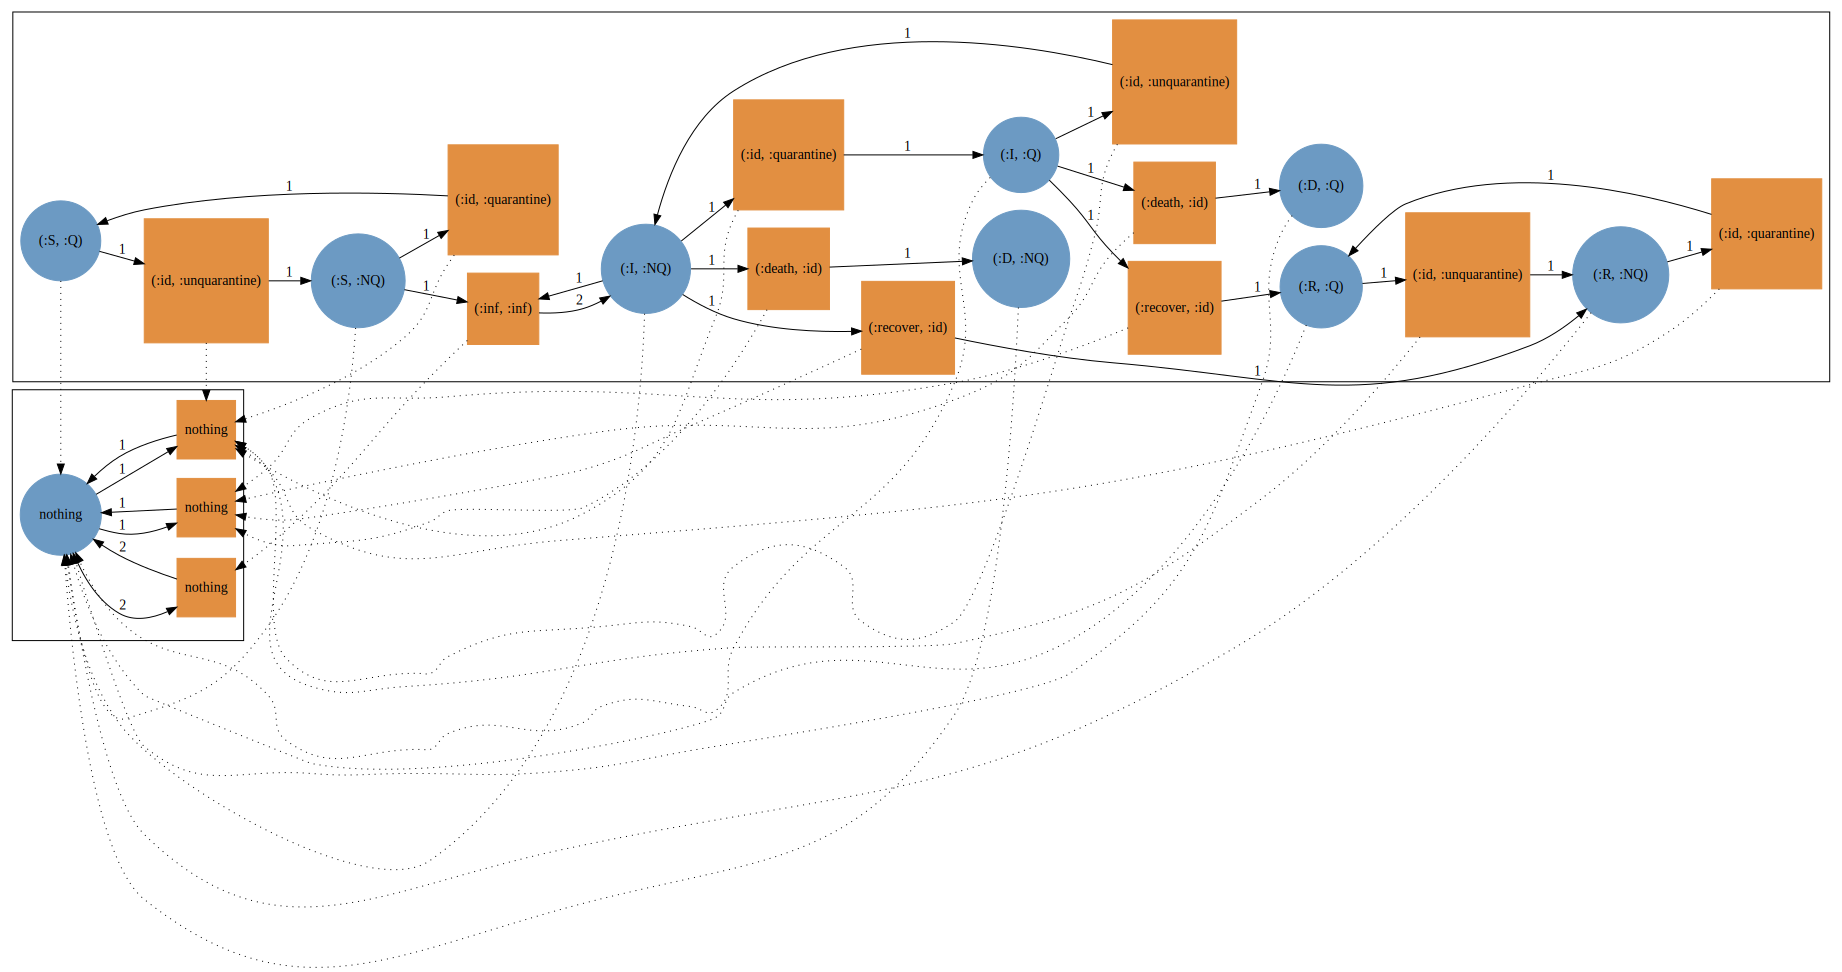

In [24]:
tgt_model = first(legs(pullback(SIRD_typed, Quarantine_typed))) ⋅ SIRD_typed
Graph(tgt_model)

In [42]:
"""Copied from Catlab PR 710"""
function migrateX(f::TightACSetTransformation, F::DeltaMigration) 
  d = Dict()
  for (ob_dom,ob_codom) in F.functor.ob_map
    if Symbol(ob_codom) ∈ keys(components(f))
      d[Symbol(ob_dom)] = f[Symbol(ob_codom)]
    end
  end
  TightACSetTransformation(NamedTuple(d), F(dom(f)), F(codom(f)))
end

strip_names_F = DeltaMigration(FinFunctor(
  Dict(:S=>:S,:T=>:T,:O=>:O,:I=>:I), 
  Dict(k => k for k in SchPetriNet.generators[:Hom]), 
  SchPetriNet, SchLabelledPetriNet), LabelledPetriNet, PetriNet)



"""Convert a LabeledPetriNet morphism into a PetriNet morphism, ignoring attrs"""
function remove_names(p::ACSetTransformation)
  init = NamedTuple([k=>collect(v) for (k,v) in pairs(components(p))])
  dom_codom = strip_names.([dom(p), codom(p)]) # turn into TIGHT transformations
  migrateX(homomorphism(dom_codom...; initial=init), strip_names_F)
end

remove_names

In [111]:
# res = decompose(tgt_model, [SIR_typed, SIRD_typed, Quarantine_typed, SIRD2_typed])
# res = decompose(tgt_model, [Quarantine_typed, SIRD2_typed])
res = decompose(tgt_model, [SIR_typed, SIRD_typed, Quarantine_typed, SIRD2_typed])

2-element Vector{Any}:
 ACSetTransformation((T = FinFunction([1, 2, 2, 3, 3, 3], 6, 3), S = FinFunction([1, 1, 1, 1], 4, 1), I = FinFunction([1, 2, 3, 3, 4, 4, 4], 7, 4), O = FinFunction([1, 2, 3, 3, 4, 4, 4], 7, 4), Name = SetFunction(#57, TypeSet(Symbol), TypeSet(Nothing))), LabelledPetriNet {T = 6, S = 4, I = 7, O = 7}, AlgebraicPetri.LabelledPetriNetUntyped{Nothing} {T = 3, S = 1, I = 4, O = 4}) => ACSetTransformation((T = FinFunction([1, 2, 2, 3, 3], 5, 3), S = FinFunction([1, 1], 2, 1), I = FinFunction([1, 2, 3, 3, 4, 4], 6, 4), O = FinFunction([1, 2, 3, 3, 4, 4], 6, 4), Name = SetFunction(#61, TypeSet(Symbol), TypeSet(Nothing))), LabelledPetriNet {T = 5, S = 2, I = 6, O = 6}, AlgebraicPetri.LabelledPetriNetUntyped{Nothing} {T = 3, S = 1, I = 4, O = 4})
                ACSetTransformation((T = FinFunction([1, 2, 2, 3, 3], 5, 3), S = FinFunction([1, 1], 2, 1), I = FinFunction([1, 2, 3, 3, 4, 4], 6, 4), O = FinFunction([1, 2, 3, 3, 4, 4], 6, 4), Name = SetFunction(#61, TypeSet(Symb

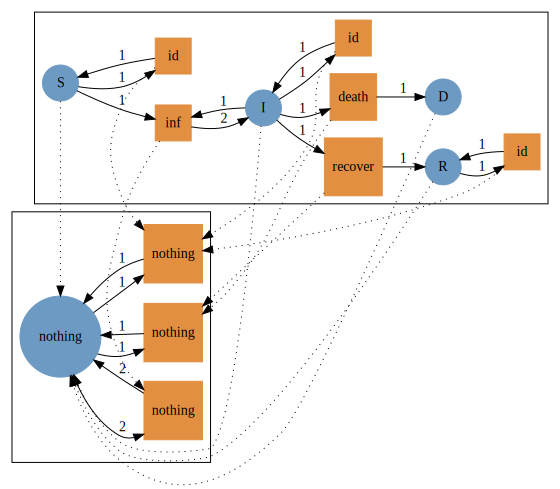

In [112]:
Graph(res[1][1])

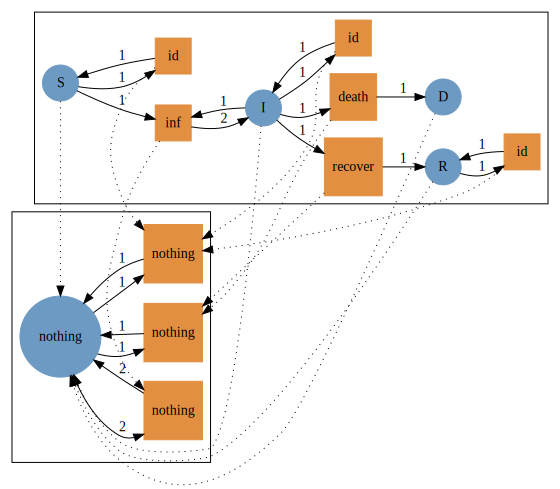

In [114]:
# So this just pull out the exact thing I sent in?
Graph(SIRD_typed)